https://zenn.dev/wsuzume/books/66b6fe7bb537b3e2b4bb/viewer/4b769d



In [ ]:
# ライブラリの導入
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# clf = linear_model.ARDRegression()
from sklearn.metrics import cohen_kappa_score

def adapt_labels(labels):
  max_label = np.max(labels) # 2 or 4

  if max_label == 2:
    labels += 2
  elif max_label == 4:
    labels -= 2
  else:
    print('Exception error! please check with np.unique(labels).')
  return labels

In [ ]:
#ファイル
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/grad_comp

Mounted at /content/drive
/content/drive/MyDrive/grad_comp


In [ ]:
# preprocess path
prepro = 'sudachi/A'

# setup data

f = open('preprocess/' + prepro + '/text.prep_train.txt', 'r')
train_data = f.read()
train_data = train_data.split('\n')
del train_data[30000]
#x_train = np.zeros((30000, len(res)))

f = open('preprocess/' + prepro + '/text.prep_test.txt', 'r')
test_data = f.read()
test_data = test_data.split('\n')
del test_data[2500]
#x_test = np.zeros((2500, len(res)))

f = open('preprocess/' + prepro + '/text.prep_dev.txt', 'r')
dev_data = f.read()
dev_data = dev_data.split('\n')
del dev_data[2500]
#x_dev = np.zeros((2500, len(res)))

# label
y_train = np.loadtxt('/content/drive/MyDrive/grad_comp/data/label.train.txt')
y_dev = np.loadtxt('/content/drive/MyDrive/grad_comp/data/label.dev.txt')

adapt_labels(y_train)
adapt_labels(y_dev)

u, counts = np.unique(y_train, return_counts=True)
print(u)
print(counts)

[0. 1. 2. 3. 4.]
[3543 5593 9227 7760 3877]


In [ ]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X) # Xにも影響しないよう
        for i, pred in enumerate(X_p):
          # こちらはエラーなし
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        # ライブラリののqwkに変更
        ll = cohen_kappa_score(y,X_p,weights='quadratic')
        return -ll # optimize.minimizeより

    # 閾値の最適化(nelder-mead法)
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        x_qwk = sp.optimize.minimize(loss_partial, initial_coef,method='Nelder-Mead')
        #print(type(x_qwk['x'])) # numpy.ndarray
        # print(x_qwk['x'][0]) # 0.5
        self.coef_ = x_qwk
        #print(x_qwk['x'])

    def predict(self, X, coef):
        X_p = np.copy(X)
        coef = self.coef_.x # self.coef_.x経由だとなぜかエラーを吐くため
        #print(coef)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_.x

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2500)
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
X_test = vectorizer.transform(test_data)

In [ ]:
X_train = X_train.toarray()
X_dev = X_dev.toarray()

model = linear_model.ARDRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_dev)
optR = OptimizedRounder()
optR.fit(y_pred, y_dev)
optimized = optR.predict(y_pred, optR.coefficients)
qwk = cohen_kappa_score(y_dev,optimized, weights='quadratic')
print(qwk)

0.4484165601031588


In [ ]:
# submit
y_pred = model.predict(X_test)
optimized = optR.predict(y_pred, optR.coefficients)
adapt_labels(optimized)
with open('src/' + prepro + '/A2500ARDR_eval.txt','w') as f:
  for y_pred in optimized:
    y_pred = int(y_pred)
    y_pred = str(y_pred)
    f.write(y_pred + '\n')

### confusion matrix

In [ ]:
y_dev_pred = model.predict(X_dev)

In [ ]:
optimized = optR.predict(y_dev_pred, optR.coefficients)
adapt_labels(optimized)
# 試しに正解率
from sklearn.metrics import accuracy_score
accuracy_score(y_dev,optimized)

0.3528

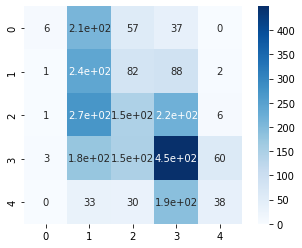

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

name = [-2,-1,0,1,2]
adapt_labels(optimized)
from sklearn.metrics import confusion_matrix
val_mat = confusion_matrix(y_dev, optimized, labels=name)

sns.heatmap(val_mat, square=True, cbar=True, annot=True, cmap='Blues')
# やはり、強い極性を判別できていない
# plt.savefig('sklearn_confusion_matrix.png')

In [ ]:
# save and load model
# モデルを保存する
import pickle
filename = 'src/Aardr_model4000.sav'
pickle.dump(model, open(filename, 'wb'))

# 保存したモデルをロードする
#loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [ ]:
# 多数決
results = np.array([result_1, result_2, result_3])
ans = [*map(lambda x: np.argmax(np.bincount(x)), result.T)]

loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# # Grid search
# X_train = X_train.toarray()
# X_dev = X_dev.toarray()

# a1 = 0
# best_qwk = 0
# best_alpha1 = 1
# for alpha1 in [1,1e-3,1e-6,1e-9]:
#     model = linear_model.ARDRegression(alpha_1=alpha1)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_dev)
#     optR = OptimizedRounder()
#     optR.fit(y_pred, y_dev)
#     optimized = optR.predict(y_pred, optR.coefficients)
#     qwk = cohen_kappa_score(y_dev,optimized, weights='quadratic')
#     if qwk > best_qwk:
#         best_qwk = qwk
#         best_alpha1 = a1
#     print("QWK = %.3f  C = %s" % (qwk, str(a1)))
# print("最適なハイパーパラメタは alpha1 = %s" % str(best_alpha1))


# model = linear_model.ARDRegression(alpha_1=best_alpha1)
# model.fit(X_train, y_train)
# y_preds = model.predict(X_test)
# optimized = optR.predict(y_preds, optR.coefficients)
# adapt_labels(optimized)
# with open('src/' + prepro + '/eval.txt','w') as f:
#   for y_pred in optimized:
#     y_pred = int(y_pred)
#     y_pred = str(y_pred)
#     f.write(y_pred + '\n')

QWK = 0.415  C = 0
QWK = 0.415  C = 0
QWK = 0.415  C = 0
QWK = 0.415  C = 0
最適なハイパーパラメタは alpha1 = 0


KeyboardInterrupt: ignored